# TP : Arbres de décision et de régression en Python

# **Arbres de décision**

## **1. Les données**
Les données portent sur les 1470 employés ou ex-employés d’une entreprise : **employes.csv**  
Nous cherchons, par un **arbre de décision**, à comprendre les facteurs de départ volontaire de ces derniers.

#### **Liste des variables**

**Attrition** : variable cible, indiquant si l’employé a quitté (« oui ») volontairement l’entreprise

**Age** :  âge de l’employé    

**Deplacements** : variable qualitative relative aux déplacements professionnels de l’employé
* 0 Pas de déplacement professionnel
* 1 Peu de déplacements professionnels
* 2 Déplacements professionnels fréquents

**Departement** : variable qualitative relative au service dans lequel travaille l’employé
* 1 Ressources humaines
* 2 Recherche & Développement
* 3 Service commercial

**DistanceDomicile** : variable quantitative, indiquant la distance domicile/travail de l’employé

**NiveauFormation** : variable qualitative correspondant au niveau d’étude de l’employé
* 1 Niv < Bac
* 2 Bac
* 3 Licence/Bachelor
* 4 Master
* 5 Doctorat

**Genre** : variable qualitative relative au genre de l’employé
* 1 Homme
* 2 Femme

**StatutMarital** : situation de l’employé
* 1 Célibataire
* 2 Divorcé
* 3 Marié

**AnnesDsEnt** : nombre d’années dans l’entreprise, de l’employé
              
**AnneesPromo** : nombre d’années depuis la dernière promotion

## **2. Importation et préparation des données**

#### **Importation des librairies**

In [1]:
import numpy as np					#Pour la manipulation de tableaux
import pandas as pd					#Pour l’importation des données
from sklearn.tree import DecisionTreeClassifier,plot_tree,DecisionTreeRegressor	#Pour l’arbre
import matplotlib.pyplot as plt     #Pour l’affichage de l’arbre
import os							#Pour le répertoire par défaut

#### **Modification du répertoire par défaut (à modifier)**

In [2]:
# os.chdir(r'C:\INFO\R4.04 Optimisation')

#### **Importation des données**

In [3]:
employes = pd.read_table('employes.csv', sep = ';', decimal = ',')

#### **Vérification - Contenu du dataframe employes**
* **head()** permet d'afficher les premières lignes (5 par défaut) du dataframe
* **dtypes** permet de lister les variables du dataframe avec leur type

In [4]:
employes.head()

,Genre,StatutMarital,AnnesDsEnt,AnneesPromo,Attrition,Age,Deplacements,Departement,DistanceDomicile,NiveauFormation
0,2.0,3,3,2,Non,59,0,Ressources humaines,2.0,4
1,2.0,1,5,4,Non,54,0,Ressources humaines,26.0,3
2,1.0,3,4,0,Non,42,0,Ressources humaines,2.0,5
3,1.0,3,3,1,Non,41,0,Ressources humaines,4.0,3
4,1.0,2,11,3,Non,38,0,Ressources humaines,2.0,3


In [5]:
employes.dtypes

Genre               float64
StatutMarital         int64
AnnesDsEnt            int64
AnneesPromo           int64
Attrition            object
Age                   int64
Deplacements          int64
Departement          object
DistanceDomicile    float64
NiveauFormation       int64
dtype: object

#### **Variables catégorielles**
Nous définissons les variables **qualitatives** comme catégorielles (categorical)

In [6]:
employes['Genre'] = employes['Genre'].astype('category')
employes['StatutMarital'] = employes['StatutMarital'].astype('category')
employes['Attrition'] = employes['Attrition'].astype('category')
employes['Deplacements'] = employes['Deplacements'].astype('category')
employes['Departement'] = employes['Departement'].astype('category')
employes['NiveauFormation'] = employes['NiveauFormation'].astype('category')

In [7]:
employes.dtypes

Genre               category
StatutMarital       category
AnnesDsEnt             int64
AnneesPromo            int64
Attrition           category
Age                    int64
Deplacements        category
Departement         category
DistanceDomicile     float64
NiveauFormation     category
dtype: object

## **3. Contraintes sur les données**
D'un point de vue **statistique**, il n'y a pas de contraintes particulières sur les variables explicatives. 
* Il faut bien sûr qu'**elles ne soient pas directement liées à la cible**. Sinon l'arbre ne révèlera que cette liaison.
* Si les variables explicatives sont liées entre elles, on peut avoir intérêts à retirer certaines d'entre elles pour plus de clarté.

Pour faire un arbre en **Python**, avec la bibliothèque **scikit-learn**, nous avons cependant deux contraintes : 
* Les variables explicatives ne doivent pas avoir de **valeurs manquantes**
* Les variables qualitatives explicatives doivent être codées **numériquement**, qu'elles soient catégorielles ou non.

### **3.1. Première contrainte : suppression des valeurs manquantes sur les variables explicatives**


S’il y en a, une méthode classique est de les remplacer : on parle **d’imputation**.  
Cette imputation peut se faire par la **moyenne**, la **médiane**, la valeur **modale** (la plus fréquente)…

#### **Détection des valeurs manquantes**

In [8]:
employes.isna().sum()

Genre               1
StatutMarital       0
AnnesDsEnt          0
AnneesPromo         0
Attrition           0
Age                 0
Deplacements        0
Departement         0
DistanceDomicile    2
NiveauFormation     0
dtype: int64

Il y a donc des valeurs manquantes dans les variables **Genre** et **DistanceDomicile**.

#### **Imputation pour la variable DistanceDomicile**
La vairable **DistanceDomicile** étant **quantitative**, on remplace les valeurs manquantes par un indicateur de tendance centrale, nous choisissons ici la **médiane**.

In [9]:
employes['DistanceDomicile'] = employes['DistanceDomicile'].fillna(employes['DistanceDomicile'].median())

Vérification, il ne devrait plus y avoir de valeurs manquantes dans la variable **DistanceDomicile**.

In [10]:
employes.isna().sum()

Genre               1
StatutMarital       0
AnnesDsEnt          0
AnneesPromo         0
Attrition           0
Age                 0
Deplacements        0
Departement         0
DistanceDomicile    0
NiveauFormation     0
dtype: int64

#### **Imputation pour la variable Genre**
La variable étant qualitative, on remplace les valeurs manquantes par le **mode**.
Comme il peut y avoir plusieurs valeurs modales, la méthode `mode()` renvoie une liste. On prend la première valeur, `mode()[0]`, elle existe toujours.

In [11]:
employes['Genre'] = employes['Genre'].fillna(employes['Genre'].mode()[0])

Vérification, il ne devrait plus y avoir de valeurs manquantes dans la variable **DistanceDomicile**, ni dans l'ensemble du dataFrame **employes**.

In [12]:
employes.isna().sum()

Genre               0
StatutMarital       0
AnnesDsEnt          0
AnneesPromo         0
Attrition           0
Age                 0
Deplacements        0
Departement         0
DistanceDomicile    0
NiveauFormation     0
dtype: int64

### **3.2. Deuxième contrainte : les modalités des variables explicatives doivent être numériques**
Quelles sont les variables concernées ?
Pour répondre, nous pouvons afficher les premières lignes du dataframe ou faire une boucle sur les variables catégorielles, pour afficher leurs modalités. 

#### **Affichage des premières lignes du dataframe**

In [13]:
employes.head()

,Genre,StatutMarital,AnnesDsEnt,AnneesPromo,Attrition,Age,Deplacements,Departement,DistanceDomicile,NiveauFormation
0,2.0,3,3,2,Non,59,0,Ressources humaines,2.0,4
1,2.0,1,5,4,Non,54,0,Ressources humaines,26.0,3
2,1.0,3,4,0,Non,42,0,Ressources humaines,2.0,5
3,1.0,3,3,1,Non,41,0,Ressources humaines,4.0,3
4,1.0,2,11,3,Non,38,0,Ressources humaines,2.0,3


#### **Affichage des modalités des variables catégorielles**
La méthode `unique()` permet d'afficher les modalités ou les valeurs d'une variable.   
Nous l'appliquons à toutes les variables catégorielles du dataframe, qui ici, sont les seules susceptibles de contenir des modalités non numériques.

In [14]:
for genre, cat in employes.dtypes.items():
    if cat == "category" :
        print("Modalités de ", genre, " : ",employes[genre].unique(), "\n")

Modalités de  Genre  :  [2.0, 1.0]
Categories (2, float64): [1.0, 2.0] 

Modalités de  StatutMarital  :  [3, 1, 2]
Categories (3, int64): [1, 2, 3] 

Modalités de  Attrition  :  ['Non', 'Oui']
Categories (2, object): ['Non', 'Oui'] 

Modalités de  Deplacements  :  [0, 2, 1]
Categories (3, int64): [0, 1, 2] 

Modalités de  Departement  :  ['Ressources humaines', 'Recherche & Développement', 'Service commercial']
Categories (3, object): ['Recherche & Développement', 'Ressources humaines', 'Service commercial'] 

Modalités de  NiveauFormation  :  [4, 3, 5, 2, 1]
Categories (5, int64): [1, 2, 3, 4, 5] 



Deux variables non numériques : 
* **Attrition** est la variable cible, cela ne pose pas de problème que ses modalités soient textuelles.
* **Departement** : il faut recoder ses modalités numériquement. Nous utiliserons un dictionnaire.

#### **Recodage de la variable Departement**
* Récupération des **anciennes** modalités dans le dictionnaire **dic_Departement**.
* Utilisation d'un **dictionnaire de correspondances** et de **`cat.rename_categories`**.

In [15]:
# Récupération de la liste des modalités
liste = list(employes["Departement"].unique())
liste

['Ressources humaines', 'Recherche & Développement', 'Service commercial']

In [16]:
# Création du dictionnaire des correspondance
dic_Departement = {}
for i in range(len(liste)):
    dic_Departement[liste[i]] = i
dic_Departement

{'Ressources humaines': 0,
 'Recherche & Développement': 1,
 'Service commercial': 2}

In [17]:
# Attribution des nouvelles modalités
employes['recodage_Departement'] = employes["Departement"].cat.rename_categories(dic_Departement)

#### **Vérification par affichage des premières valeurs du dataframe**

In [18]:
employes.head()

,Genre,StatutMarital,AnnesDsEnt,AnneesPromo,Attrition,Age,Deplacements,Departement,DistanceDomicile,NiveauFormation,recodage_Departement
0,2.0,3,3,2,Non,59,0,Ressources humaines,2.0,4,0
1,2.0,1,5,4,Non,54,0,Ressources humaines,26.0,3,0
2,1.0,3,4,0,Non,42,0,Ressources humaines,2.0,5,0
3,1.0,3,3,1,Non,41,0,Ressources humaines,4.0,3,0
4,1.0,2,11,3,Non,38,0,Ressources humaines,2.0,3,0


## **4. Définition de la cible et des variables explicatives**
Ce n'est pas une obligation, mais cela donne un peu de clarté au code, nous enregistrons la variable cible et les variables explicatives dans deux variables : 
* **cible** : la variable cible **Attrition**
* **explic** : le dataframe des variables explicatives

In [19]:
# Création de la cible 
cible = employes['Attrition']

In [20]:
# Création du tableau des variables explicatives 
# Récupération des noms des variables
print(list(employes.columns))

['Genre', 'StatutMarital', 'AnnesDsEnt', 'AnneesPromo', 'Attrition', 'Age', 'Deplacements', 'Departement', 'DistanceDomicile', 'NiveauFormation', 'recodage_Departement']


In [21]:
#Création du tableau des variables explicatives (la variable Attrition a été enlevée de la liste)
explic = employes.loc[:,['Genre', 'StatutMarital', 'AnnesDsEnt', 'AnneesPromo', 'Age', 'Deplacements', 
                         'recodage_Departement', 'DistanceDomicile', 'NiveauFormation']]

## **5. Arbre de décision**
Trois étapes : 
* Définir les **paramètres** de l'arbre par la fonction `DecisionTreeClassifier` : `max_depth`: profondeur maximale de l'arble, `min_samples_split` : taille minimale des noeuds susceptibles d'être scindés, `min_samples_leaf` : taille minimum des feuilles de l'arbre...
* Calcul des noeuds de l'arbre par la méthode `fit`
* **Représentation graphique** de l'arbre par la fonction `plot_tree`

#### **Paramétrage et calcul de l'arbre**

In [22]:
#Profondeur max : 3, taille minimum des feuilles : 5
class_arbre=DecisionTreeClassifier(max_depth = 3, min_samples_leaf=5)
#Calcul des informations de l’arbre dans digit_free
digit_tree=class_arbre.fit(explic, cible)

#### **Représentation graphique de l’arbre**

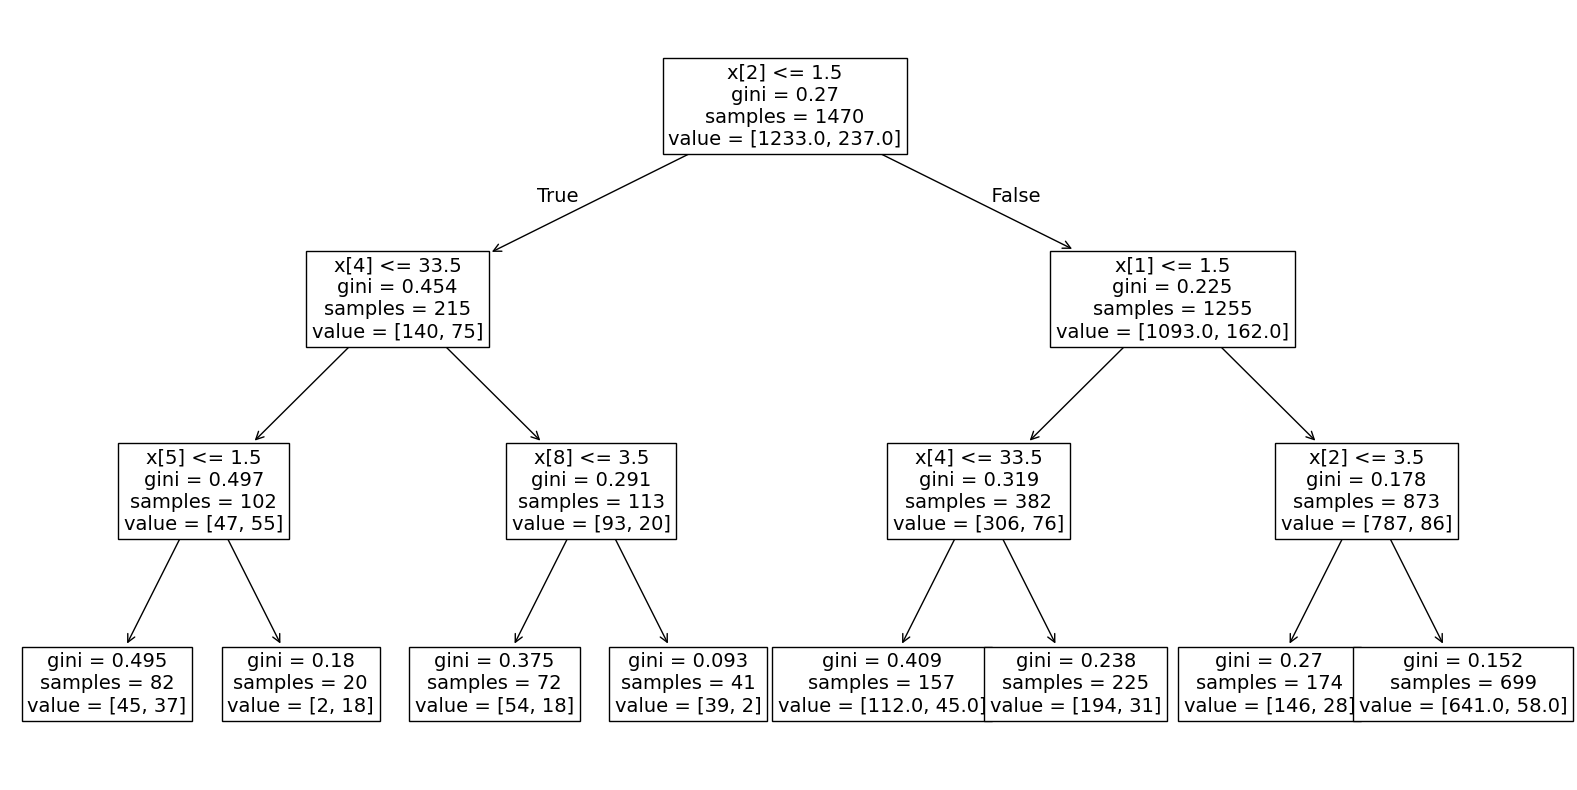

In [23]:
plt.figure(figsize = (20,10))
plot_tree(digit_tree, fontsize=14)
plt.show()

#### **Améliorations**
* Coloration des nœuds en fonction de la valeur de l'indice de **Gini**.
* Création d'une liste **nomvar** contenant les noms des variables explicatives, pour permettre l'affichage des variables sur l'arbre.

In [24]:
# liste nomvar
nomvar  = ['Genre', 'StatutMarital', 'AnnesDsEnt', 'AnneesPromo', 'Age', 'Deplacements', 
           'recodage_Departement', 'DistanceDomicile', 'NiveauFormation']

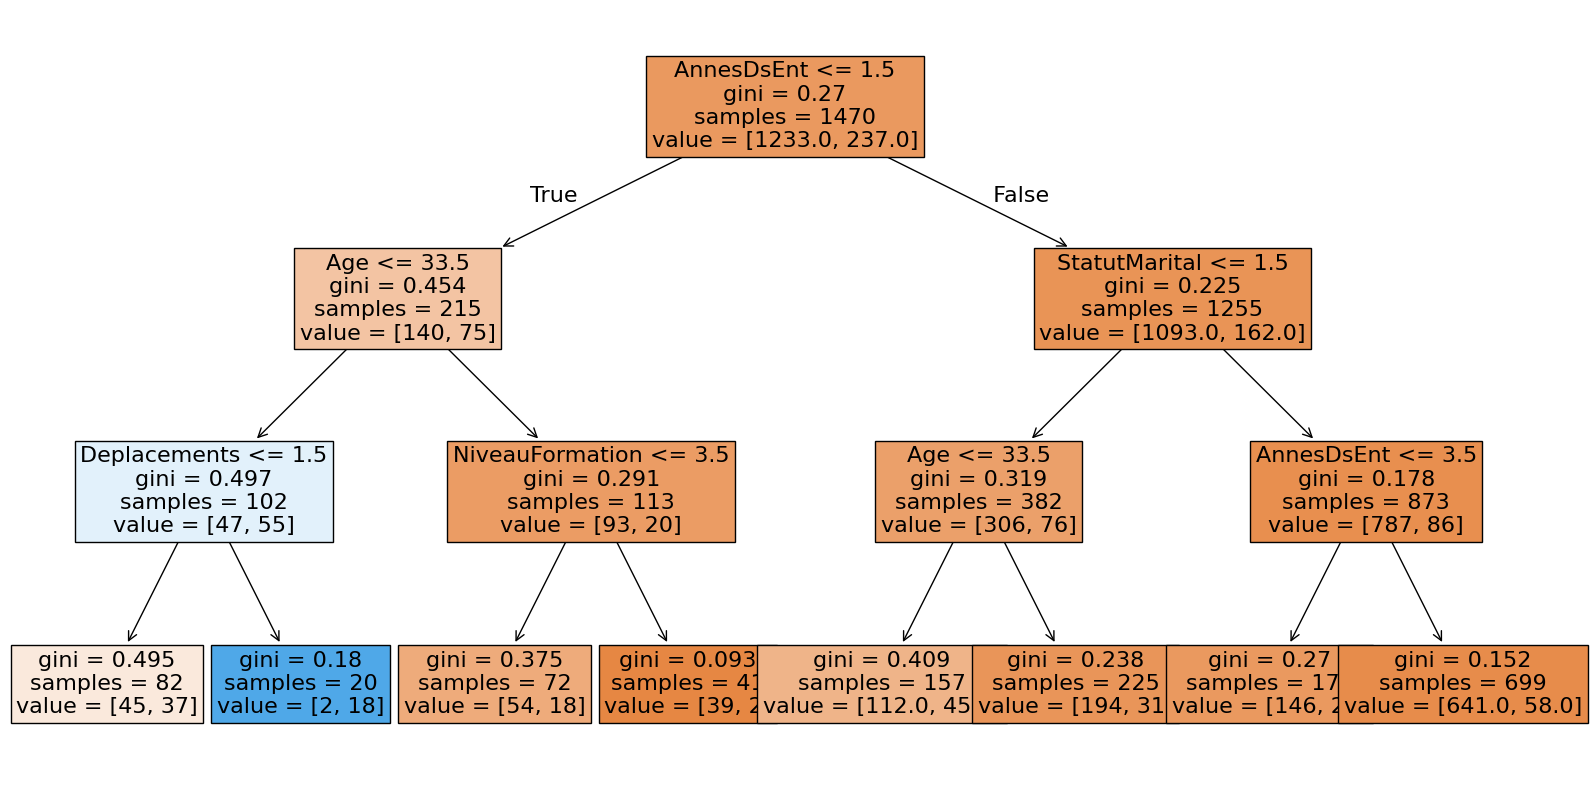

In [25]:
plt.figure(figsize = (20,10))  # set plot size (denoted in inches)
plot_tree(digit_tree, 
          fontsize = 16,
          filled=True,
          feature_names=nomvar)
plt.show()

**Exercice (facultatif)** : vérifier les valeurs obtenues sur les trois premiers nœuds de l’arbre : 

## **6. Attention aux variables qualitatives nominales !**
Dans l'arbre de décision créé précédemment, les variables qualitatives recodées sont systématiquement traitées sous forme **ordinale** (exemple=3.5, StatutMarital<=1.5 : NiveauFormation<=1.5....   
Ce qui n'est pas adapté aux variables **nominales**.   
Si l'on veut traiter correctement ces variables, il faut créer autant de nouvelles variables **binaires** que de modalités des variables nominales. On peut pour cela utiliser la fonction **get_dummies**

In [26]:
employes.dtypes

Genre                   category
StatutMarital           category
AnnesDsEnt                 int64
AnneesPromo                int64
Attrition               category
Age                        int64
Deplacements            category
Departement             category
DistanceDomicile         float64
NiveauFormation         category
recodage_Departement    category
dtype: object

Application de la fonction **get_dummies** sur les deux variables nominales **Departement** et **StatutMarital** 

In [27]:
employes = pd.get_dummies(employes, columns=['Departement','StatutMarital'])

In [28]:
employes.head()

,Genre,AnnesDsEnt,AnneesPromo,Attrition,Age,Deplacements,DistanceDomicile,NiveauFormation,recodage_Departement,Departement_Recherche & Développement,Departement_Ressources humaines,Departement_Service commercial,StatutMarital_1,StatutMarital_2,StatutMarital_3
0,2.0,3,2,Non,59,0,2.0,4,0,False,True,False,False,False,True
1,2.0,5,4,Non,54,0,26.0,3,0,False,True,False,True,False,False
2,1.0,4,0,Non,42,0,2.0,5,0,False,True,False,False,False,True
3,1.0,3,1,Non,41,0,4.0,3,0,False,True,False,False,False,True
4,1.0,11,3,Non,38,0,2.0,3,0,False,True,False,False,True,False


## **7. Nouvel arbre de décision**
#### **Variables cible et explicatives**

In [29]:
#Création de la cible 
cible = employes['Attrition']

In [30]:
#Variables explicatives 
print(list(employes.columns))

['Genre', 'AnnesDsEnt', 'AnneesPromo', 'Attrition', 'Age', 'Deplacements', 'DistanceDomicile', 'NiveauFormation', 'recodage_Departement', 'Departement_Recherche & Développement', 'Departement_Ressources humaines', 'Departement_Service commercial', 'StatutMarital_1', 'StatutMarital_2', 'StatutMarital_3']


In [31]:
# Variables explicatives
explic = employes.loc[:,['Genre', 'AnnesDsEnt', 'AnneesPromo', 'Age', 'Deplacements',
                         'DistanceDomicile', 'NiveauFormation', 'Departement_Recherche & Développement', 
                         'Departement_Ressources humaines', 'Departement_Service commercial', 
                         'StatutMarital_1', 'StatutMarital_2', 'StatutMarital_3']]

#### **Paramétrage de l'arbre**

In [32]:
# Profondeur max : 3, taille minimum des feuilles : 5
class_arbre=DecisionTreeClassifier(max_depth = 3, min_samples_leaf=5)
# Calcul des informations de l’arbre dans digit_free
digit_tree=class_arbre.fit(explic, cible)

In [33]:
# Récupération des noms des variables explicatives
nomvar = list(explic.columns)

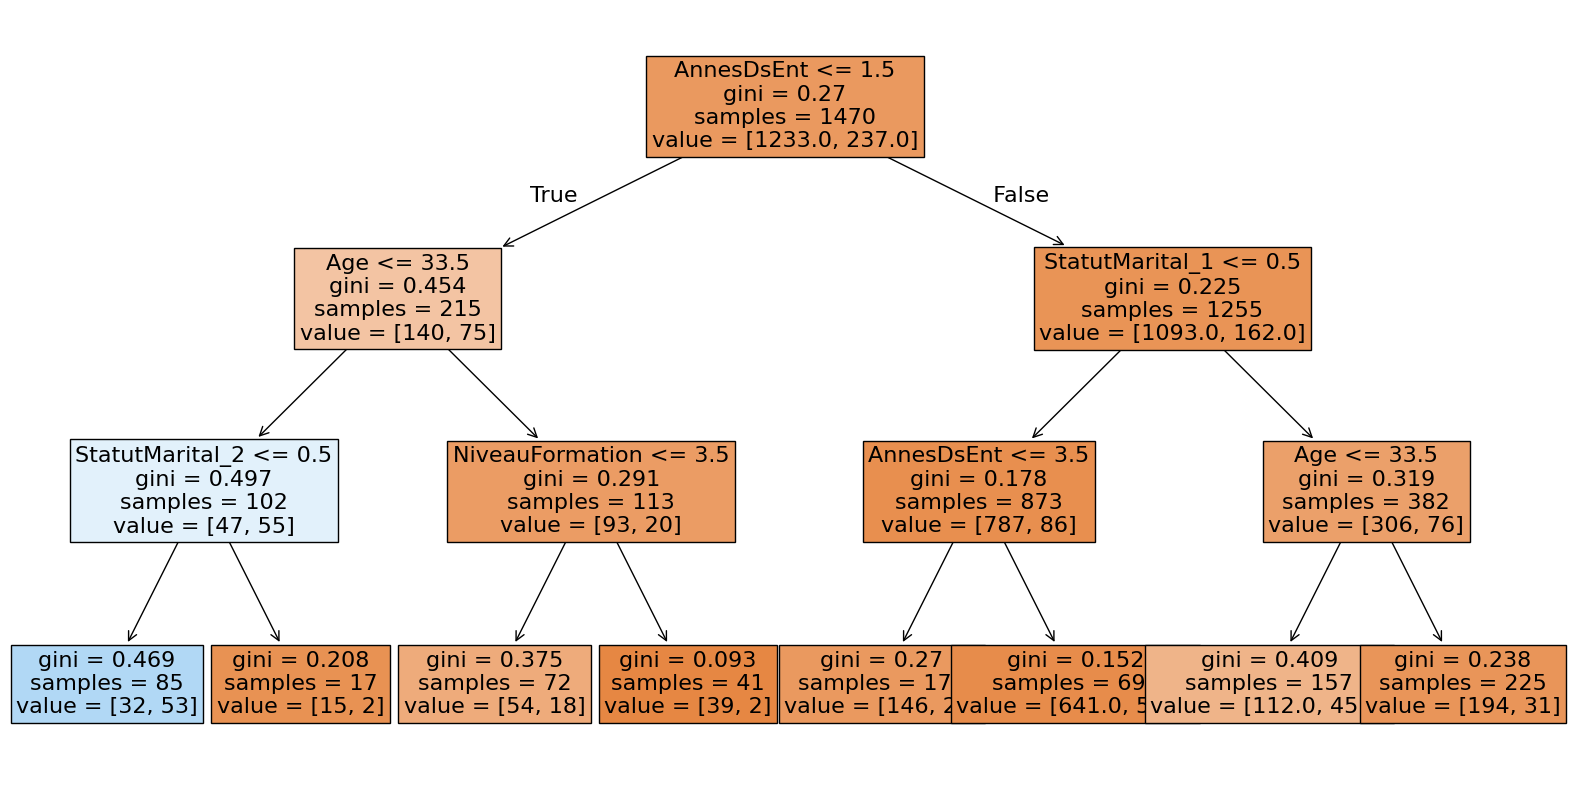

In [34]:
plt.figure(figsize = (20,10))  # set plot size (denoted in inches)
plot_tree(digit_tree, 
          fontsize = 16,
          filled=True,
          feature_names=nomvar)
plt.show()

# **Arbres de régression** 
Nous allons tester un arbre de régression avec comme **cible**, la variable quantitative **AnneesDsEnt** représentant le nombre d'années dans l'entreprise.  
La variable **Attrition** devenant explicative, ses modalités doivent être recodées numériquement. 
## **1. Recodage numérique de la variable Attrition**

In [35]:
#Recodage
listemod_attr = employes["Attrition"].unique()   

# Création d'un dictionnaire pour recoder numériquement les modalités de Departement.1
dic = {}
for i in range(len(listemod_attr)) : 
    dic[listemod_attr[i]]=i

# Attribution des nouvelles modalités
employes['recodageAttrition'] = employes["Attrition"].cat.rename_categories(dic)

## **2. Arbre de régression : variable cible AnnesDsEnt**

In [36]:
list(employes.columns)

['Genre',
 'AnnesDsEnt',
 'AnneesPromo',
 'Attrition',
 'Age',
 'Deplacements',
 'DistanceDomicile',
 'NiveauFormation',
 'recodage_Departement',
 'Departement_Recherche & Développement',
 'Departement_Ressources humaines',
 'Departement_Service commercial',
 'StatutMarital_1',
 'StatutMarital_2',
 'StatutMarital_3',
 'recodageAttrition']

In [37]:
#Création de la cible 
cible = employes['AnnesDsEnt']

In [38]:
#Variables explicatives 
explic = employes.loc[:,['Genre', 'AnneesPromo','Age', 'recodageAttrition','Deplacements', 'DistanceDomicile', 
                         'NiveauFormation', 'Departement_Recherche & Développement', 
                         'Departement_Ressources humaines', 'Departement_Service commercial', 
                         'StatutMarital_1', 'StatutMarital_2', 'StatutMarital_3']]
# Récupération des noms des variables explicatives
nomvar = list(explic.columns)

#### **Paramétrage et affichage de l'arbre**

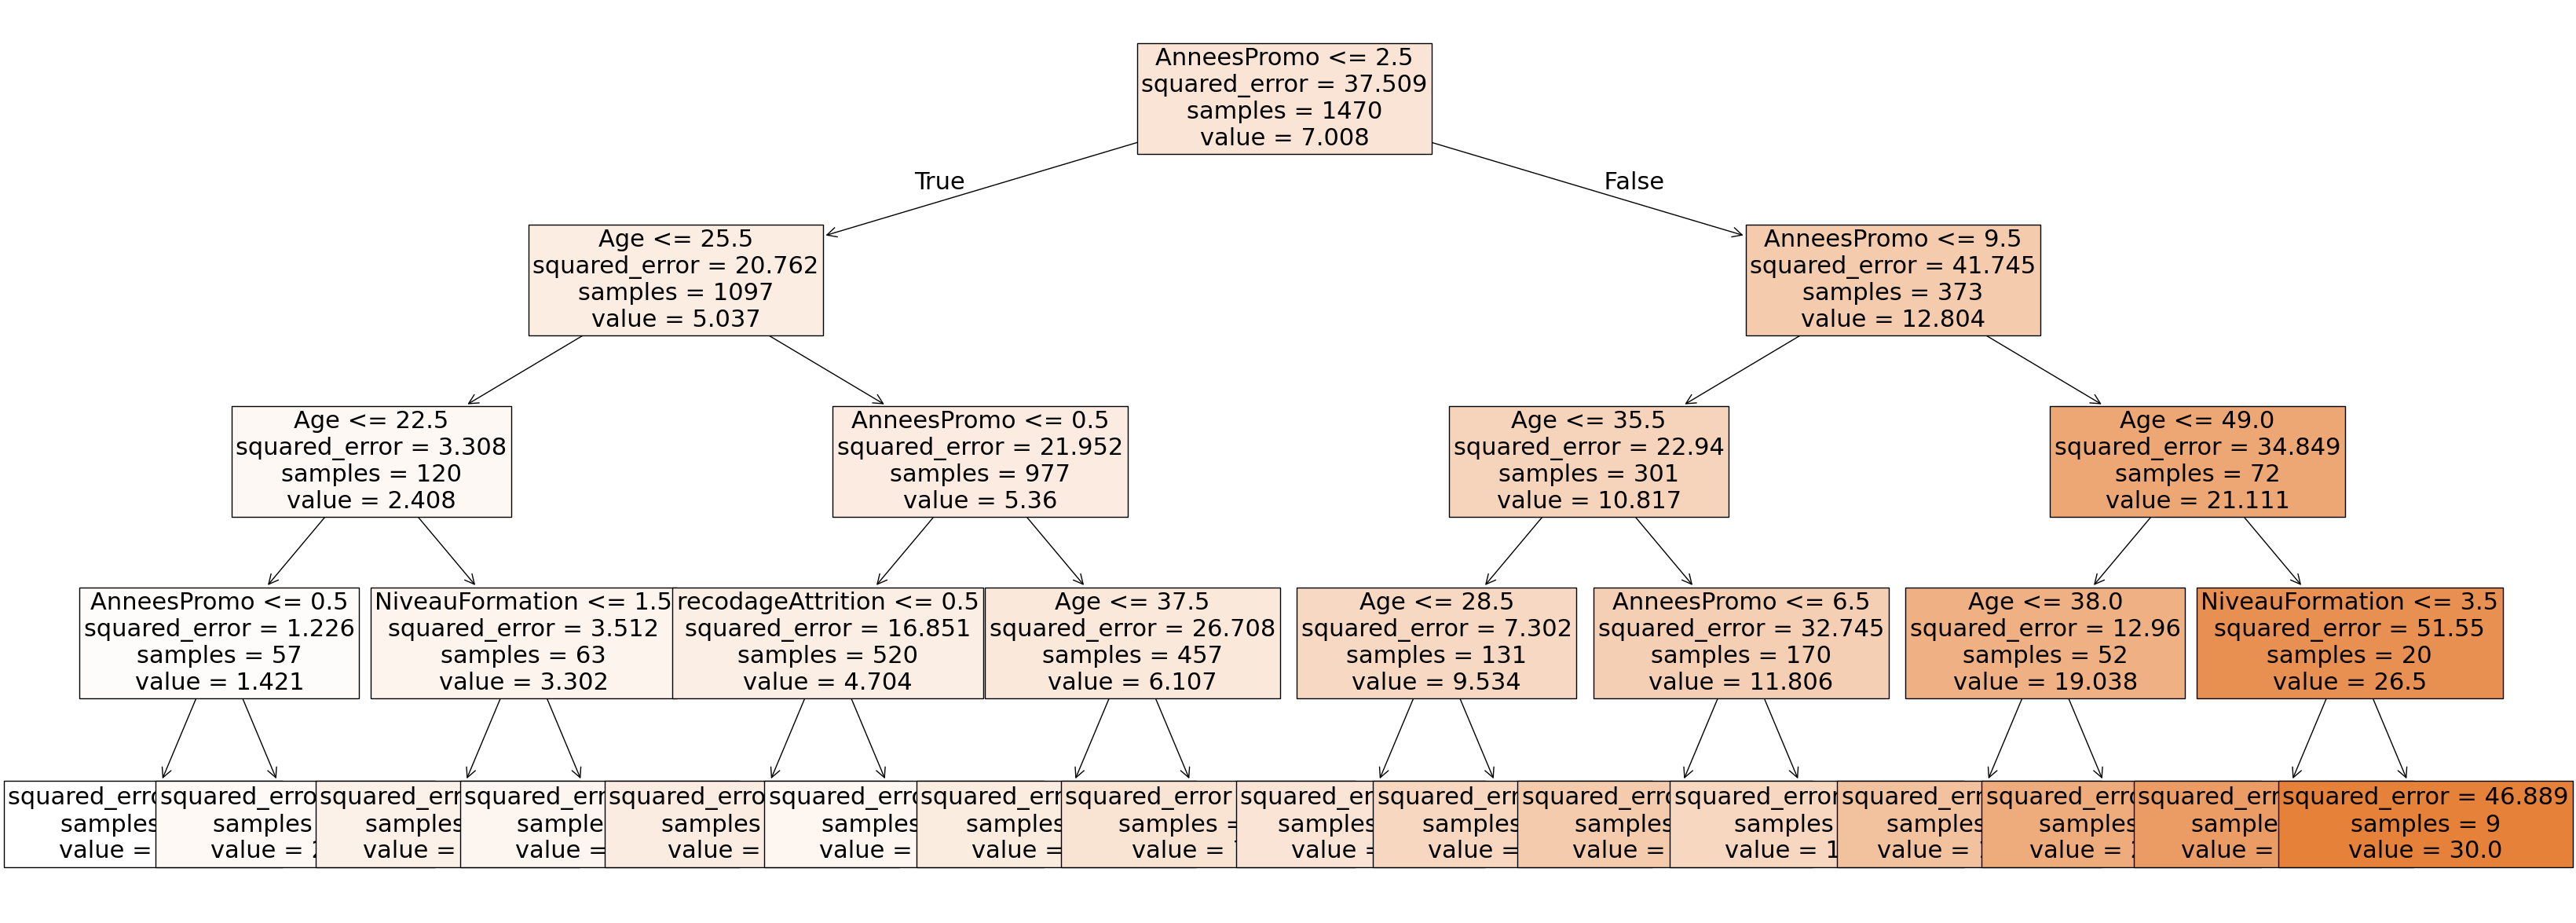

In [39]:
# Paramétrage préalable de l'arbre
class_arbre = DecisionTreeRegressor(max_depth = 4, min_samples_leaf=2)
# Calcul des informations de l’arbre dans digit_free
digit_tree = class_arbre.fit(explic, cible)

#Représentation graphique de l’arbre
plt.figure(figsize = (40,15))  # set plot size (denoted in inches)
plot_tree(digit_tree,
          fontsize = 22,
          filled=True,
          feature_names=nomvar)
plt.show()
